In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score ,roc_curve, auc
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC  

C:\Users\carin\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\Users\carin\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.o

In [2]:
# Import dataset
df = pd.read_csv('data/preprocessed_data.csv')

# Train-Test Split

In [3]:
# Remove stopwords
stop = stopwords.words('english')
# Include other words that occur frequently
newStopWords = ['blush','nars','orgasm','colour','color']
stop.extend(newStopWords)
df['review_processed_stop'] = df['review_processed'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [4]:
X = df.drop(['repurchase_again','date','review_length'], axis=1)
y = df['repurchase_again']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)

(5029, 31)
(1677, 31)


In [5]:
# create dictionary which maps each token to its corresponding tf-idf score to get more domain specific stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(stop_words= stop, max_df=0.85)
X_train_dtm = vect.fit_transform(X_train['review_processed_stop'])
word2tfidf = dict(zip(vect.get_feature_names(), vect.idf_))
domain_specific_stopwords = sorted(word2tfidf, key = word2tfidf.get)[:30]
stop.extend(domain_specific_stopwords)

In [6]:
X_train_dtm.shape

(5029, 8653)

In [7]:
#Creating another tf-idf vectorizer to do topic modeling
tfidf_vectorizer = TfidfVectorizer(stop_words= stop, min_df=0.04)
X_train_dtm = tfidf_vectorizer.fit_transform(X_train['review_processed_stop'])
X_test_dtm = tfidf_vectorizer.transform(X_test['review_processed_stop'])

In [8]:
X_train_dtm.shape

(5029, 163)

In [9]:
# GridSearch to find right number of topics
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Define Search Param
search_params = {
  'n_components': [3, 4, 5, 6, 7, 8, 9, 10],
  'learning_decay': [.5, .7, .9]
}

# Init the Model
lda = LDA(max_iter=5, learning_method='online', learning_offset=50., random_state=0)

# Init Grid Search Class
gridsearch = GridSearchCV(lda, param_grid=search_params)
# Do the Grid Search
gridsearch.fit(X_train_dtm)

print("Best Model's Params: ", gridsearch.best_params_)
print("Best Log Likelihood Score: ", gridsearch.best_score_)

C:\Users\carin\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps
C:\Users\carin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\carin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When

In [10]:
# Best Model
best_lda_model = gridsearch.best_estimator_

X_train_LDA = best_lda_model.transform(X_train_dtm)
X_test_LDA = best_lda_model.transform(X_test_dtm)

In [11]:
# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

In [12]:
### Train Data ###

# index names
docnames_train = ["TrainDoc" + str(i) for i in range(len(X_train))]

# Make the pandas dataframe
df_document_topic_train = pd.DataFrame(np.round(X_train_LDA, 2), columns=topicnames, index=docnames_train)

# Get dominant topic for each document
dominant_topic_train = np.argmax(df_document_topic_train.values, axis=1)
df_document_topic_train['dominant_topic'] = dominant_topic_train
print(df_document_topic_train.head())
print('\nDistribution of topics')
print(df_document_topic_train['dominant_topic'] .value_counts())

           Topic0  Topic1  Topic2  dominant_topic
TrainDoc0    0.10    0.79    0.10               1
TrainDoc1    0.09    0.81    0.09               1
TrainDoc2    0.83    0.09    0.08               0
TrainDoc3    0.12    0.18    0.71               2
TrainDoc4    0.83    0.09    0.08               0

Distribution of topics
0    2821
1    1157
2    1051
Name: dominant_topic, dtype: int64


In [13]:
### Test Data

# index names
docnames_test = ["TestDoc" + str(i) for i in range(len(X_test))]

# Make the pandas dataframe
df_document_topic_test = pd.DataFrame(np.round(X_test_LDA, 2), columns=topicnames, index=docnames_test)

# Get dominant topic for each document
dominant_topic_test = np.argmax(df_document_topic_test.values, axis=1)
df_document_topic_test['dominant_topic'] = dominant_topic_test
print(df_document_topic_test.head())
print('\nDistribution of topics')
print(df_document_topic_test['dominant_topic'] .value_counts())

          Topic0  Topic1  Topic2  dominant_topic
TestDoc0    0.25    0.45    0.30               1
TestDoc1    0.73    0.16    0.12               0
TestDoc2    0.70    0.15    0.15               0
TestDoc3    0.79    0.08    0.13               0
TestDoc4    0.59    0.31    0.10               0

Distribution of topics
0    968
1    355
2    354
Name: dominant_topic, dtype: int64


In [14]:
from sklearn.decomposition import TruncatedSVD
clusters = dominant_topic_train
# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(X_train_LDA)
# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

Text(0.5, 1.0, 'Segregation of Topic Clusters')

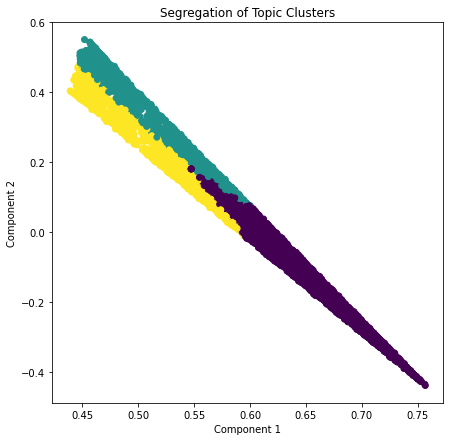

In [15]:
# Plot
plt.figure(figsize=(7, 7))
plt.scatter(x, y, c=clusters)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

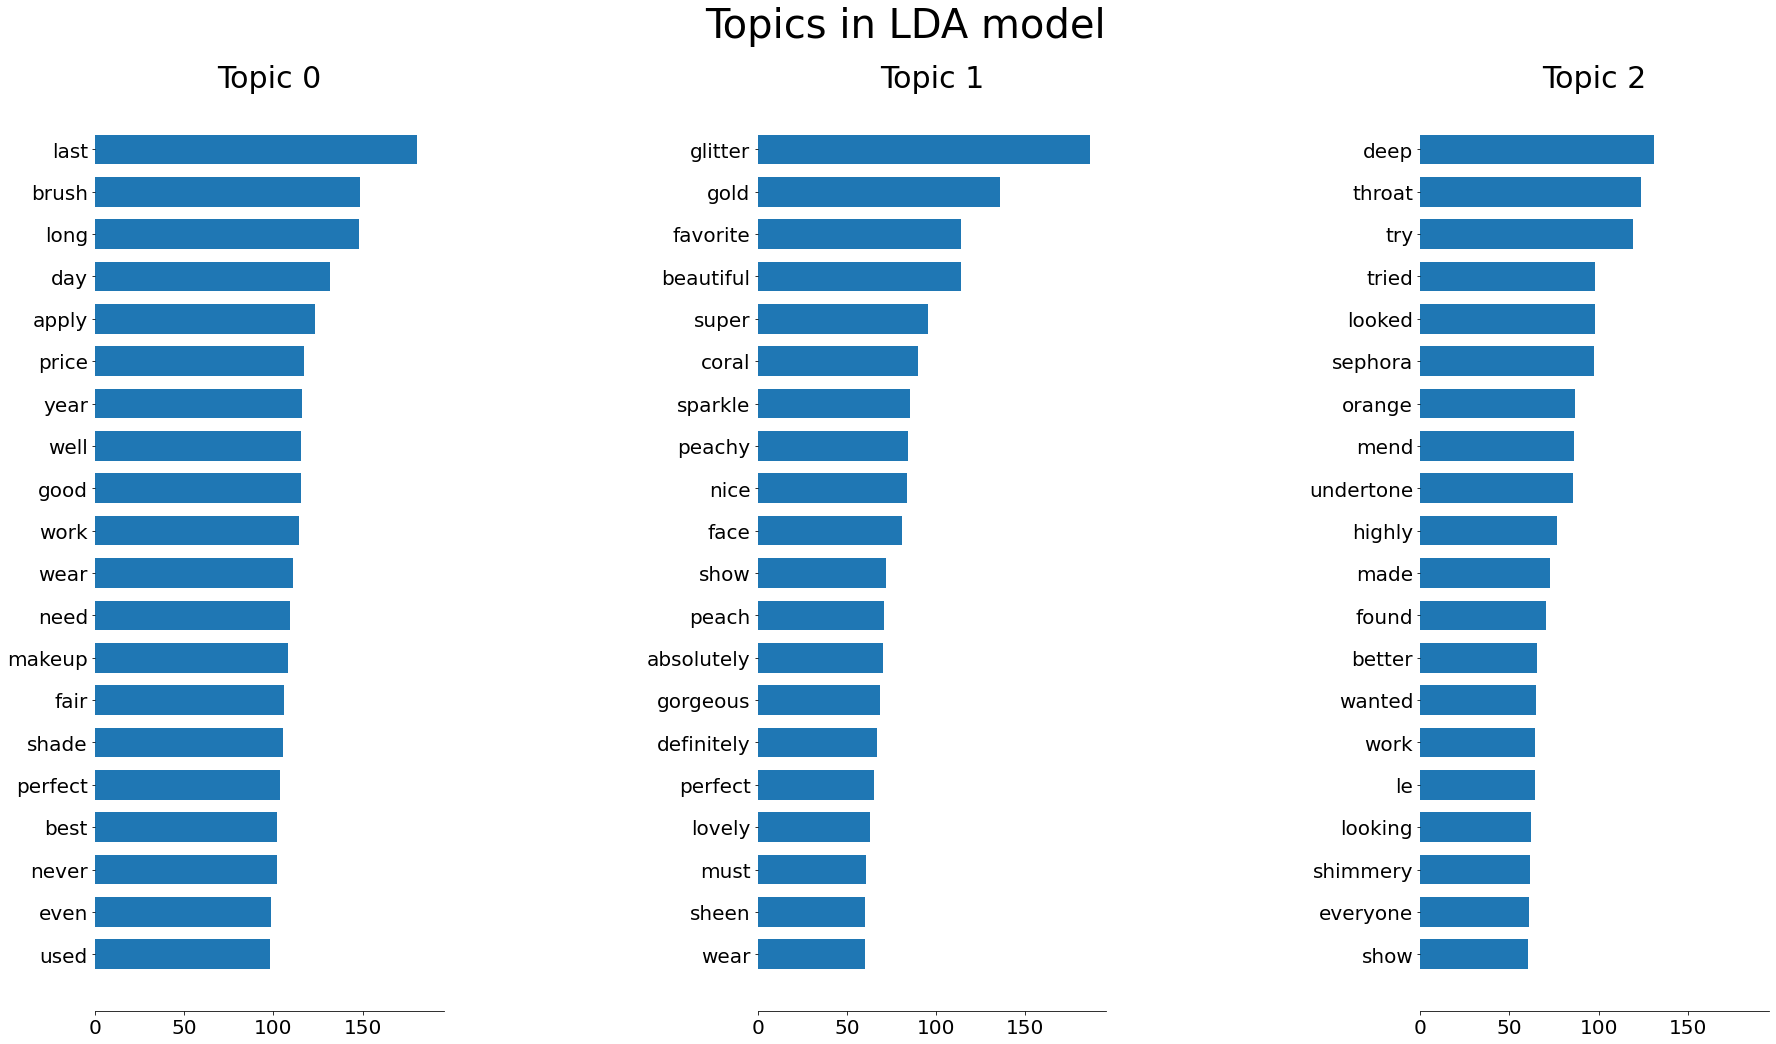

In [16]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 3, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20
words = tfidf_vectorizer.get_feature_names()
plot_top_words(best_lda_model, words, n_top_words, 'Topics in LDA model')

In [17]:
# Add topic feature into products
X_train['dominant_topic'] = dominant_topic_train
X_test['dominant_topic'] = dominant_topic_test

C:\Users\carin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\carin\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
X_train['dominant_topic'].value_counts()

0    2821
1    1157
2    1051
Name: dominant_topic, dtype: int64

In [19]:
X_test['dominant_topic'].value_counts()

0    968
1    355
2    354
Name: dominant_topic, dtype: int64

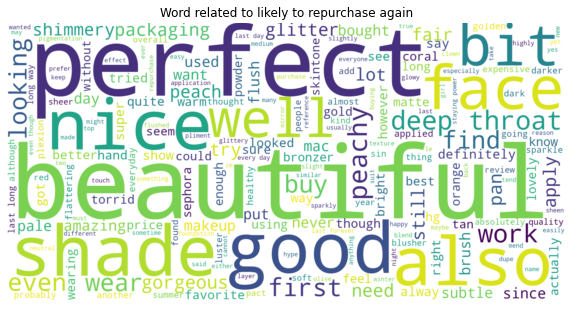

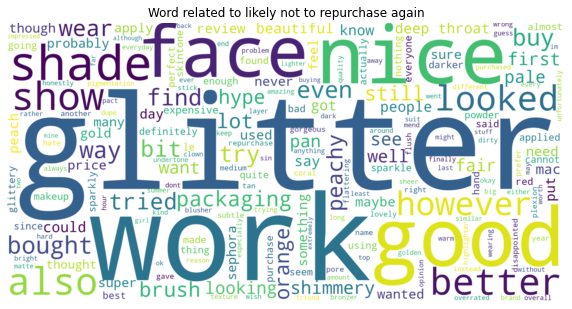

In [20]:
# Wordcloud
repurchase_products = df[df['repurchase_again'] == 1]
donot_repurchase_products = df[df['repurchase_again'] == 0]
repurchase_reviews = " ".join(r for r in repurchase_products['review_processed_stop'])
donot_repurchase_reviews = " ".join(r for r in donot_repurchase_products['review_processed_stop'])

# Create and generate a word cloud image that excludes domain-specific and common stopwords
repurchase_wordcloud = WordCloud(stopwords=stop, background_color="white", width=2000, height=1000).generate(repurchase_reviews)
donot_repurchase_wordcloud = WordCloud(stopwords=stop, background_color="white", width=2000, height=1000).generate(donot_repurchase_reviews)

# Display the generated image
plt.figure(figsize=(10, 7))
plt.imshow(repurchase_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word related to likely to repurchase again")
plt.show()

plt.figure(figsize=(10, 7))
plt.imshow(donot_repurchase_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word related to likely not to repurchase again")
plt.show()

# Export data for model building

In [21]:
# Check all columns in train set
X_train.columns

Index(['review', 'repurchase', 'packaging', 'review_processed',
       'product_Blush - Angelika', 'product_Blush - Deep Throat',
       'product_Blush - Dolce Vita', 'product_Blush - Exhibit A',
       'product_Blush - Luster', 'product_Blush - Madly',
       'product_Blush - Orgasm', 'product_Blush - Sex Appeal',
       'product_Blush - Sin', 'product_Blush - Taj Mahal',
       'product_Blush - Torrid', 'product_Mata Hari Blush',
       'product_Super Orgasm ', 'age_25-29', 'age_30-35', 'age_36-43',
       'age_44-55', 'age_56 & Over', 'age_Under 18', 'polarity',
       'subjectivity', 'word_count', 'char_count', 'avg_word_length',
       'twitter_sentiment', 'twitter_subjectivity', 'review_processed_stop',
       'dominant_topic'],
      dtype='object')

In [22]:
# Keep only numerical columns
X_train_numeric = X_train.drop(['review','review_processed','review_processed_stop'],axis=1)
X_test_numeric = X_test.drop(['review','review_processed','review_processed_stop'],axis=1)

In [23]:
# Extract column names from numeric and vectorizer
column_names = list(X_train_numeric.columns) + tfidf_vectorizer.get_feature_names()

In [24]:
# Concatenate numerical and text features
from scipy.sparse import hstack
X_train_final = pd.DataFrame(hstack([X_train_numeric, X_train_dtm]).toarray(), columns = column_names)
X_test_final = pd.DataFrame(hstack([X_test_numeric, X_test_dtm]).toarray(), columns = column_names)

In [25]:
# Check initial numerical train shape
X_train_numeric.shape

(5029, 29)

In [26]:
# Check initial text train shape
X_train_dtm.toarray().shape

(5029, 163)

In [27]:
# Check final train shape
X_train_final.shape

(5029, 192)

In [28]:
# Check final test shape
X_test_final.shape

(1677, 192)

In [30]:
# Export data
X_train_final.to_csv('data/X_train.csv', index = False)
X_test_final.to_csv('data/X_test.csv', index = False)
y_train.to_csv('data/y_train.csv', index = False)
y_test.to_csv('data/y_test.csv', index = False)

PermissionError: [Errno 13] Permission denied: 'data/X_train.csv'

# Model Building

In [34]:
# Import dataset 
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/y_test.csv')

In [32]:
# Check class distribution
y_train.value_counts()

1    3798
0    1231
Name: repurchase_again, dtype: int64

In [33]:
# Set seed
seed = 123

# Logistic Regression

In [37]:
from pprint import pprint
from sklearn.pipeline import Pipeline

In [47]:
# Define a pipeline combining a text feature extractor with a simple classifier
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('logreg', LogisticRegression(solver='liblinear')),
])

# Define parameters to tune
parameters = {
    'vect__use_idf': (True, False),
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__min_df': (0.01, 0.03, 0.05),
    'vect__stop_words': (None, stop, 'english'),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)), # unigrams or bigrams
    'logreg__C': (0.01, 1, 10),
    'logreg__penalty': ('l1', 'l2'),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='roc_auc')

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)

grid_search.fit(X_train_final, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

logreg_best = gridsearch.best_estimator_

Performing grid search...
pipeline: ['vect', 'logreg']
parameters:
{'logreg__C': (0.01, 1, 10),
 'logreg__penalty': ('l1', 'l2'),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__min_df': (0.01, 0.03, 0.05),
 'vect__ngram_range': ((1, 1), (1, 2)),
 'vect__stop_words': (None,
                      ['i',
                       'me',
                       'my',
                       'myself',
                       'we',
                       'our',
                       'ours',
                       'ourselves',
                       'you',
                       "you're",
                       "you've",
                       "you'll",
                       "you'd",
                       'your',
                       'yours',
                       'yourself',
                       'yourselves',
                       'he',
                       'him',
                       'his',
                       'himself',
                       'she',
                       "she's",
    

ValueError: Found input variables with inconsistent numbers of samples: [192, 3352]

In [ ]:
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=seed)
pred_test_full =0
cv_score =[]
i=1
for train_index,test_index in kf.split(X_train,y_train):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y.loc[train_index],y.loc[test_index]
    
    #model
    lr = LogisticRegression()
    lr.fit(xtr,ytr)
    score = roc_auc_score(yvl,lr.predict(xvl))
    print('ROC AUC score:',score)
    cv_score.append(score)    
    pred_test = lr.predict_proba(x_test)[:,1]
    pred_test_full +=pred_test
    i+=1

# SVM

In [ ]:
# Tuning hyperparamaters
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

# Initialise GridSearch for SVC
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, n_jobs = -1, cv = 5)

# Fit GridSearchCV Model
svm = grid.fit(X_train,y_train)

# Optimal parameters
print(svm.best_estimator_)

# Model Prediction 
y_pred_svm = svm.predict(X_test)
y_pred_svm_proba = svm.predict_proba(X_test)[:, 1]

In [ ]:
# Evaluation
print('Accuracy:', accuracy_score(y_train, y_pred_svm))
print('Precision:', precision_score(y_train, y_pred_svm))
print('Recall:', recall_score(y_train, y_pred_svm))
print('ROC_AUC:', roc_auc_score(y_train, y_pred_svm_proba))
print('ROC Curve:', roc_curve(y_train, y_pred_svm_proba))
print('AUC:', roc_curve(y_train, y_pred_svm_proba))

print('\nConfusion Matrix:')
print(metrics.confusion_matrix(y_test, y_pred_svm))

print('\nClassification Report:')
print(metrics.confusion_matrix(y_test, y_pred_svm))

# Naive Bayes

In [ ]:
# Define a pipeline combining a text feature extractor with a simple classifier
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

# Define parameters to tune
parameters = {
    'vect__use_idf': (True, False),
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__min_df': (0.01, 0.03, 0.05),
    'vect__stop_words': (None, stop, 'english'),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)), # unigrams or bigrams
    'nb__alpha': (0.00001, 0.000001),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)

grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [7]:
nb = MultinomialNB()
X_train_c = X_train.copy()
X_test_c = X_test.copy()
nb.fit(X_train_c, y_train)
y_pred_class_train_c = nb.predict(X_train_c)
y_pred_class_test_c = nb.predict(X_test_c)

C:\Users\Gladys Koh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Input X must be non-negative

In [8]:
X_train

,repurchase,packaging,product_Blush - Angelika,product_Blush - Deep Throat,product_Blush - Dolce Vita,product_Blush - Exhibit A,product_Blush - Luster,product_Blush - Madly,product_Blush - Orgasm,product_Blush - Sex Appeal,...,want,warm,way,wear,wearing,well,without,work,worth,year.1
0,0.258065,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.381524,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000
1,0.774194,0.666667,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.298906,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000
2,0.774194,0.666667,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.278143,0.00000
3,0.774194,0.333333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.199938,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000
4,0.258065,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.29833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5024,0.258065,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.249052,0.000000,0.000000,0.000000,0.0,0.0,0.265122,0.000000,0.000000,0.00000
5025,0.709677,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000
5026,0.774194,0.333333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.497845,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000
5027,0.258065,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.000000,0.637283,0.0,0.0,0.000000,0.000000,0.000000,0.00000


In [ ]:
print('--- Train ---')
print('Accuracy:', metrics.accuracy_score(y_train, y_pred_class_train_c))
print('Precision:', metrics.precision_score(y_train, y_pred_class_train_c))
print('Recall:', metrics.recall_score(y_train, y_pred_class_train_c))
print('ROC_AUC:', metrics.roc_auc_score(y_train, y_pred_class_train_c))

print('\nConfusion Matrix:')
print(metrics.confusion_matrix(y_train, y_pred_class_train_c))


print('\n--- Test ---')
print('Accuracy:', metrics.accuracy_score(y_test, y_pred_class_test_c))
print('Precision:', metrics.precision_score(y_test, y_pred_class_test_c))
print('Recall:', metrics.recall_score(y_test, y_pred_class_test_c))
print('ROC_AUC:', metrics.roc_auc_score(y_test, y_pred_class_test_c))

print('\nConfusion Matrix:')
print(metrics.confusion_matrix(y_test, y_pred_class_test_c))